# Pruebas del método de volumen finito
- Óscar Alvarado
- Oscar Esquivel
- Jose Porras

In [1]:
import numpy as np
import plotly.graph_objects as go
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

## Índice

1. [Mallado](#Mallado)
2. [Mallado escalonado](#Staggered-grids)
3. [SIMPLE](#SIMPLE)
4. [Coeficientes](#Coeficientes)
5. [Difusión](#Difusión)
6. [Convección](#Convección)
7. [Sistema de ecuaciones](#Sistema-de-ecuaciones)
8. [Problemas](#Problemas)
    - [Una dimensión](#Una-dimensión)
    - [Una dimensión, no uniformidad](#Una-dimensión,-no-uniformidad)
    - [Una dimensión con convección](#Una-dimensión-con-convección)
    - [Dos dimensiones](#Dos-dimensiones)
    - [Tres dimensiones](#Tres-dimensiones)
9. [Problemas importando las clases](#Problemas-importando-las-clases)
    - [Una dimensión](#Una-dimensión-con-clases)
    - [Una dimensión, no uniformidad](#Una-dimensión,-no-uniformidad-con-clases)
    - [Una dimensión con convección](#Una-dimensión-con-convección-con-clases)
    - [Dos dimensiones](#Dos-dimensiones-con-clases)
    - [Tres dimensiones](#Tres-dimensiones-con-clases)
10. [Presión y velocidad](#Presión-y-velocidad)
    - [Una dimensión](#Una-dimensión-escalonado)
    - [Dos dimensiones](#Dos-dimensiones-escalonado)
11. [Condiciones iniciales](#Problema-condiciones-iniciales)

## Mallado

In [2]:
class Mesh():
    """
    Clase del mallado
    """
    def __init__(self, dim, volumes = None, lengths = None):
        """
        Constructor de la clase Malla.
        """

        self.volumes = (1,1,1)
        self.lengths = (0.01, 0.01, 0.01)

        #----default values for positions and separations of the grid-------------
        self.coords = [(0.005,) for _ in range(3)] # Coordenadas de los centros de los volúmenes
        self.dominios = [tuple([0.]+[self.coords[i][0]]+[self.lengths[i]]) for i in range(3)]
        self.deltas = [(0,) for _ in range(3)]
        # Hasta aquí tenemos un cubito

        self.__tags = {} # El etiquetado de todos los nodos sin fronteras
        self.__tags_fronteras = {} # El etiquetado de las fronteras
        
        self.dim = dim
        if isinstance(volumes, int):  self.volumes = (volumes, 1, 1)
        if isinstance(lengths, (int, float)):  self.lengths = (lengths, lengths/10, lengths/10)
        
        # Si los parámetros son tuplas (pero no necesariamente sería una tupla de 3), arreglamos eso:
        if isinstance(volumes, tuple):
            faltan = 3 - len(volumes)
            self.volumes = volumes + tuple([1 for i in range(faltan)])
        if isinstance(lengths, tuple): 
            faltan = 3 - len(lengths)
            self.lengths = lengths + tuple([lengths[0]/10 for i in range(faltan)])
        #---------------------------------------------------------------
        
        # if volumes and lengths are given, initialize values acording to dimension
        if (volumes and lengths):       
            self.uniform_grid()
            self.init_tags()
            self.init_tags_fronteras()
    
    
    def uniform_grid(self):
        l = np.array(self.lengths) # Para el manejo con numpy
        v = np.array(self.volumes)
        d = l/v # Separación entre todos los nodos de cada dimensión
        start = d/2 # La frontera "inicial" del arreglo
        stop = l-d/2 # La frontera "final" del arreglo
        self.coords = [tuple(np.linspace(strt, stp, vol)) \
                       for strt, stp, vol in list(zip(start, stop, v))] # Meshgrid posible
        dominios = [np.insert(arr,(0,len(arr)),[0, l[idx]]) \
                    for idx, arr in enumerate(self.coords)] # Coordenadas + fronteras
        # Separación entre los nodos (Aquí hay que ver cómo es cuando tenemos un grid 
        # de 2x1x1 ya cuando se haga el FVM
        self.deltas = [self.set_deltas(dom)  if len(self.set_deltas(dom)) != 0 \
                       else (dom[-1],) for dom in dominios]
        self.dominios = [tuple(dom) for dom in dominios]
        #self.faces = [tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) for coords in self.coords]
        self.faces = [(self.dominios[idx][0],) + tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) \
                          + (self.dominios[idx][-1],) for idx, coords in enumerate(self.coords)]
        self.get_deltas_faces()
        self.get_grids()
    
    
    def set_deltas(self, dominio):
        """
        Método para obtener la distancia que hay entre los nodos
        """
        return tuple((dominio[1:]-dominio[:-1])[1:-1])


    # Creo que esto no se usará, pero estuvo chida la deducción, lo dejo de todos modos xd
    #def totalDomNodes(self):
    #    d_1 = 6*self.volumes[0] + 1
    #    d_2 = self.volumes[1]*d_1 - self.volumes[0]*(self.volumes[1] - 1)
    #    d_3 = self.volumes[2]*d_2 - self.volumes[0]*self.volumes[1]*(self.volumes[2] - 1)
    #    return d_3
    
    def init_tags(self):
        """
        Método que etiqueta las caras adyacentes de cada volumen dependiendo de la geometría. Pone un {} 
        (diccionario vacío) cuando es una frontera, una 'F' cuando es una cara interna y un 'Off' cuando 
        no se está contando esa cara por las dimensiones del problema. 
        """
        self.__tags = {}
        X, Y, Z = self.volumes
        for z in range(1,Z+1):
            for y in range(1,Y+1):
                for x in range(1,X+1):                   
                    t = b = n = s = "Off"
                    e = w = "F"
                    if x == 1: w = {}
                    elif x == X: e = {}
                    if self.dim > 1:
                        n = s = "F"
                        if y == 1: n = {}
                        elif y == Y: s = {}
                        if self.dim == 3:
                            t = b = "F"
                            if z == 1: t = {}
                            elif z == Z: b = {}
                    self.__tags[f"{x}-{y}-{z}"] = {"E": e, "W": w, "N": n, "S": s, "T": t, "B": b, 
                                             "coord": [self.dominios[0][x], self.dominios[1][y], 
                                                       self.dominios[2][z]]}
    
    def init_tags_fronteras(self):
        """
        Método para etiquetar las fronteras dependiendo de la dimensión, sólo se les da la propiedad de 
        existir o no existir.
        """
        self.__tags_fronteras = {}
        X, Y, Z = [len(dom) for dom in self.dominios]
        for z in range(Z):
            for y in range(Y):
                for x in range(X):
                    t = b = n = s = "Off"
                    e = w = "ON"
                    if self.dim > 1: 
                        n = s = "ON"
                        if self.dim == 3: t = b = "ON"
                    # El siguiente cacho de código es para saber si nos encontramos con una frontera
                    if x==0 or y==0 or z==0 or x==(X-1) or y==(Y-1) or z==(Z-1):
                        var = None
                        if y != 0 and y != (Y - 1):
                            if z != 0 and z != (Z - 1):
                                if x == 0: var = "W"; value = w
                                elif x == (X - 1): var = "E"; value = e
                                else: continue
                            elif x != 0 and x != (X - 1):
                                if z == 0: var = "T"; value = t
                                elif z == (Z - 1): var = "B"; value = b
                                else: continue
                            else: continue
                            self.__tags_fronteras[f"{x}-{y}-{z}"] = {"frontera": {var: value},
                                                 "coord": [self.dominios[0][x], self.dominios[1][y],
                                                           self.dominios[2][z]], "cond": {}} 
                        elif z != 0 and z != (Z - 1):
                            if x != 0 and x != (X - 1):
                                if y == 0: var = "N"; value = n
                                elif y == (Y - 1) : var = "S"; value = s
                                self.__tags_fronteras[f"{x}-{y}-{z}"] = {"frontera": {var: value},
                                                 "coord": [self.dominios[0][x], self.dominios[1][y], 
                                                           self.dominios[2][z]], "cond": {}} 
                        else: continue
            
    def tag_wall(self, direction, tag, value):
        """
        Método para etiquetar fronteras dada la dirección, el tipo de condición de frontera y el valor.
        """
        for key in self.__tags.keys():
            if isinstance(self.__tags[key][direction], dict):
                self.__tags[key][direction][tag] = value
        for key in self.__tags_fronteras.keys():
            if self.__tags_fronteras[key]["frontera"].get(direction) == "ON":
                self.__tags_fronteras[key]["cond"][tag] = value

    def tag_wall_dirichlet(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Dirichlet dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["D"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["D"] =  value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "D", value[idx])
            else:
                self.tag_wall(direction, "D", value)
                    
    def tag_wall_neumann(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Neumann dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["N"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["N"] = value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "N", value[idx])
            else:
                self.tag_wall(direction, "N", value)
                    
    def tag_wall_source(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Neumann dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["S"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["S"] = value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "S", value[idx])
            else:
                self.tag_wall(direction, "S", value)
                
                
    def tag_wall_insulated(self, direction, coords=None):
        """
        Método para etiquetar fronteras con condición de aislamiento.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["I"] = None
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["I"] = None
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "I", None)
            else:
                self.tag_wall(direction, "I", None)
                
    
    def set_dominio(self, dominio, faces=None):
        """
        Método para definir el dominio de estudio dadas unas coordenadas en forma de tupla.
        """
        # Si 'dominio' no es tupla, transforma 'dominio' a la tupla unidimensional (dominio,)
        # Tendría que ser una tupla de tuplas/listas/arreglos para que sea válido.
        if not isinstance(dominio, (tuple, int, float)): # Creo que si es una lista o un arreglo, no int o float
            tupla = (tuple(dominio), self.dominios[1], self.dominios[2])
            dominio = tupla
        # Asigna los atributos de la mesh correspondientes    
        self.dominios = [tuple(dominio[i]) for i in range(3)]
        self.coords = [tuple(dominio[i][1:-1]) for i in range(3)]
        self.lengths = tuple([dominio[i][-1] for i in range(3)])
        self.volumes = tuple([len(dominio[i][1:-1]) for i in range(3)])
        #self.deltas = [self.set_deltas(np.array(dominio[i])) for i in range(3)]
        self.deltas = [self.set_deltas(np.array(dom))  if len(self.set_deltas(np.array(dom))) != 0 \
                       else (dom[-1],) for dom in self.dominios]
        
        if faces: 
            # Si me está pasando una lista (o sea, es de una dimensión)
            if isinstance(faces[0], (int, float)):
                self.faces = tuple(dominio[0]) + tuple(faces) + tuple(dominio[-1])
            else: # Suponemos aquí que nos está pasando una lista de listas (o tupla de tuplas)
                for idx, face_1dim in enumerate(faces):
                    faces[idx] = (dominio[idx][0], ) + tuple(face_1dim) + (dominio[idx][-1], )
                self.faces = faces
        else: 
            self.faces = [(self.dominios[idx][0],) + tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) \
                          + (self.dominios[idx][-1],) for idx, coords in enumerate(self.coords)]
        self.get_deltas_faces()
        self.init_tags()
        self.init_tags_fronteras()
        self.get_grids()
    
    def get_grid_deltas_dominios(self, axis=0, orientation="E", reverse=False):
        deltas_dominios = []
        self.grid_deltas_dominios = np.array([])
        dominios = [np.array(dom) for dom in self.dominios]
        coords = [np.array(coord) for coord in self.coords]
        for direction in range(3):
            if direction != axis:
                if len(dominios[direction]) == 3:
                    deltas_dominios.append(dominios[direction][1])
                else:
                    deltas_dominios.append(coords[direction])
            else:
                deltas_dominios.append(dominios[direction][1:] - dominios[direction][:-1])
        if orientation == "E" or orientation == "S" or orientation == "B":
            if reverse:
                deltas_dominios[axis] = deltas_dominios[axis][:-1]
            else:
                deltas_dominios[axis] = deltas_dominios[axis][1:]
        else:
            if reverse:
                deltas_dominios[axis] = deltas_dominios[axis][1:]
            else:
                deltas_dominios[axis] = deltas_dominios[axis][:-1]
        self.grid_deltas_dominios = np.meshgrid(deltas_dominios[0], deltas_dominios[1], deltas_dominios[2], 
                                                indexing='ij')
        return self.grid_deltas_dominios
    
    
    def get_deltas_faces(self):
        self.deltas_faces = []
        faces = [np.array(caras) for caras in self.faces]
        dominio = [np.array(doms) for doms in self.dominios]
        for direction in range(3):
            self.deltas_faces.append(faces[direction][1:] - faces[direction][:-1])
            
    def get_grids(self):
        self.grid_deltas = np.array([])
        self.grid_faces = np.array([])
        self.grid_coords = np.array([])
        deltas = self.deltas
        coords = self.coords
        faces = self.faces
        self.grid_deltas = np.meshgrid(deltas[0], deltas[1], deltas[2], indexing='ij')
        self.grid_coords = np.meshgrid(coords[0], coords[1], coords[2], indexing='ij')
        self.grid_faces = np.meshgrid(faces[0], faces[1], faces[2], indexing='ij')
                
    
    def info(self):
        """
        Método para imprimir información relevante del mallado
        """
        print('=====================================')
        print('     MESH INFORMATION   ')
        print('=====================================')
        print("\nMesh type: Cartesian")
        print(f"Number of dimensions of mesh: {self.dim}")
        variables = "X Y Z".split()
        for idx in range(self.dim):
            var = variables[idx]
            print(f"\n ----- {var}-axis -----")
            print(f"Number of {var.lower()} volumes: {self.volumes[idx]}")
            print(f"Lenght {var.lower()} of problem domain: {self.lengths[idx]}")
            print(f"List of {var.lower()} positions of volumes: \n{self.coords[idx]}")
            print(f"List of {var.lower()} positions of domain nodes: \n{self.dominios[idx]}")
            
            
    def draw(self):
        """
        Método para graficar la malla. Este método se invoca hasta que se hayan inizializado todas las condiciones
        de frontera.
        """
        # Graficamos las fronteras, sean o no activas
        dic_colors = {"D": "darkturquoise", "N": "red", "S": "magenta", "Off": "white", "I": "gray"}
        condiciones = [list(self.__tags_fronteras[key]["cond"].keys())[0] \
                       if list(self.__tags_fronteras[key]["frontera"].values())[0] == "ON" \
                       else "Off" for key in list(self.__tags_fronteras.keys())]
        colores = [dic_colors[cond] for cond in condiciones]
        # Obtenemos las coordenadas de las fronteras y de los nodos internos.
        coordenadas = [] # Aquí se pondrán las coordenadas de las fronteras
        coord = [] # Aquí las coordendas de los nodos internos
        for i in range(3):
            coordenadas.append([self.__tags_fronteras[key]["coord"][i] \
                                for key in list(self.__tags_fronteras.keys())])
            coord.append([self.__tags[key]["coord"][i] for key in list(self.__tags.keys())])
        fig = go.Figure(data = go.Scatter3d(x = coordenadas[0], y = coordenadas[1], z = coordenadas[2],
                                          mode = 'markers', marker = dict(color = colores, 
                                                                          symbol = "square", size = 2)))
        fig.add_trace(go.Scatter3d(x = coord[0], y = coord[1], z = coord[2],
                                              mode = 'markers', marker = dict(color = "blue", size = 5)))
        fig.show()


    def get_area(self, direction = 0, extended=False):
        """
        Método que regresa las áreas del volumen en la dirección indicada
        """
        perpendicular = [i for i in range(3) if i != direction]
        num_fronteras = self.volumes[direction]
        #if inplace:
        #    arreglo = [self.deltas_faces[idx][1:-1] if idx in perpendicular else np.ones(num_fronteras) \
        #          for idx in range(3)]
        #else:
        arreglo = [self.deltas_faces[idx] if idx in perpendicular else np.ones(num_fronteras) \
                  for idx in range(3)]
        if extended:
            arreglo = [self.deltas_faces[idx] if idx in perpendicular else np.ones(num_fronteras+1) \
                  for idx in range(3)]
        areas_grid = np.meshgrid(arreglo[0], arreglo[1], arreglo[2], indexing='ij')
        
        return areas_grid[perpendicular[0]]*areas_grid[perpendicular[1]]
    
    def stag_def(self, direct=0):
        """
        Gives the parameters needed for defining a staggered mesh via the 'setDominio()'
        method.
        """
        # Lo que antes eran los dominios en un eje, ahora serán las caras. En los demás ejes queda igual.
        clean = lambda x: list(x[2:-2])
        clean_2 = lambda x: list(x[1:-1])
        caras = [clean(self.dominios[idx]) if direct==idx else clean_2(self.faces[idx]) for idx in range(3)]
        
        # Lo que antes eran las caras en un eje, ahora serán los dominios. En los demás ejes queda igual.
        # Sólo movemos el eje del que estemos creando el mallado escalonado
        dominio = [self.faces[idx] if direct==idx else self.dominios[idx] for idx in range(3)]
        return tuple(dominio), tuple(caras)

[Volver al índice](#Índice)

## Staggered grids

In [3]:
class StagMesh(Mesh):
    def __init__(self, malla_origen, direction=0, stag="b"):
        self.malla_origen = malla_origen
        dim = malla_origen.dim
        super().__init__(dim)
        doms, facs = malla_origen.stag_def(direction, stag)
        self.set_dominio(dominio = doms, faces = list(facs))

[Volver al índice](#Índice)

## SIMPLE

In [4]:
class Simple():
    def __init__(self, mallas, Γ=None, ρ=None):
        self.malla_escalares = mallas[0]
        self.mallas_vectoriales = mallas[1:]
        #λ_vel = lambda indice: np.array([0 if indice!=idx else 1 for idx in range(3)])
        #self.velocity_star = [np.zeros(np.array(malla.grid_coords[0].shape) + λ_vel(idx)) for idx, malla in \
        #                      enumerate(self.mallas_vectoriales)]
        self.velocity_star = [np.zeros(np.array(malla.grid_coords[0].shape)) for malla in self.mallas_vectoriales]
                              
        for idx, vel_star in enumerate(self.velocity_star):
            tmp = self.velocity_star[idx][:1,:,:]
            self.velocity_star[idx][:1,:,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"W")).reshape(tmp.shape)
            tmp = self.velocity_star[idx][-1:,:,:]
            self.velocity_star[idx][-1:,:,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"E")).reshape(tmp.shape)
            if self.mallas_vectoriales[idx].dim > 1:
                tmp = self.velocity_star[idx][:,:1,:]
                self.velocity_star[idx][:,:1,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"S")).reshape(tmp.shape)
                tmp = self.velocity_star[idx][:,-1:,:]
                self.velocity_star[idx][:,-1:,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"N")).reshape(tmp.shape)
            if self.mallas_vectoriales[idx].dim == 3:
                tmp = self.velocity_star[idx][:,:,:1]
                self.velocity_star[idx][:,:,:1] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"B")).reshape(tmp.shape)
                tmp = self.velocity_star[idx][:,:,-1:]
                self.velocity_star[idx][:,:,-1:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"T")).reshape(tmp.shape)
                
        self.pressure_star = np.zeros(self.malla_escalares.grid_coords[0].shape)
        
        self.coef_pressure = Coefficients(malla, mesh_type="p",pressure_star=self.pressure_star,
                                          velocity_star=self.velocity_star)
        self.coef_velocity = [Coefficients(mesh,mesh_type="v",pressure_star=self.pressure_star,
                                          velocity_star=self.velocity_star,idx=idx,strategy="b") \
                              for idx, mesh in enumerate(self.mallas_vectoriales)]
        if Γ:
            #coef_pressure.set_diffusion(Γ) Este no lo puedo agregar aún porque necesito los coefs de vel
            [coef.set_diffusion(Γ) for coef in self.coef_velocity]
        if ρ:
            #self.coef_pressure.set_convection(ρ) Este no lo puedo agregar aún porque necesito los coefs de vel
            [coef.set_convection(ρ, self.velocity_star, simple=True) for coef in self.coef_velocity]

    def get_boundary_condition(self, malla, direction):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].values())[0]
                condicion.append(cond)
        return condicion
            
    def get_approximation(self, ur=None):
        coef_pressure = self.coef_pressure
        coef_velocity = self.coef_velocity
        pressure_star = self.pressure_star
        velocity_star = self.velocity_star

[Volver al índice](#Índice)

## Coeficientes

In [5]:
class Coefficients():
    """
    Class that defines the coefficients that every node needs to form it's
    discrete equation that represent the diferential equation. All the coefficients
    needed for a scalar quantity (also called variable or unkown) are contained
    in one object (instance of this class).
    """    
    def __init__(self, mesh):
        self.dim = mesh.dim
        self._mesh = mesh
        vols = mesh.volumes
        
        self.aP = np.zeros(vols)
        self.aE = np.zeros(vols)
        self.aW = np.zeros(vols)
        self.Su = np.zeros(vols)
        self.Sp = np.zeros(vols)

        if self.dim > 1:
            self.aN = np.zeros(vols)
            self.aS = np.zeros(vols)
        if self.dim == 3:
            self.aT = np.zeros(vols)
            self.aB = np.zeros(vols)
        
    def set_pressure_gradient(self,pressure_star,direction=0,strategy="b"):
        """
        Método que inicializa los coeficientes específicos de la velocidad
        """
        sign = 1
        if strategy=="f": sign = -1
        malla = self._mesh
        self.pressure_star = pressure_star
        self.strategy = strategy
        
        # Calculando áreas importantes
        areas = malla.get_area(direction=direction)
        grad_presion = -sign*np.diff(pressure_star, axis=direction)
        
        self.Su -= grad_presion*areas
        
    def get_continuity_coeffs(self, mallas_velocidad, velocity_star, pressure_star, ds):
        malla_presion = self._mesh
        tupla_extra = lambda x: tuple([0 if x!=i else 2 for i in range(3)])
        general_coeffs = [np.zeros(np.array(malla.volumes) + np.array(tupla_extra(idx))) \
                              for idx,malla in enumerate(mallas_velocidad)]
        b = general_coeffs.copy()
        areas = [malla.get_area(direction=idx) for idx, malla in enumerate(mallas_velocidad)]
        areas_ext = [malla_presion.get_area(direction=idx,extended=True) \
                     for idx,_ in enumerate(mallas_velocidad)]
        for idx, area in enumerate(areas):
            volumes = mallas_velocidad[idx].volumes
            slice_b = [slice(None,None) if idx!=i else slice(1, vols+1) for i, vols in enumerate(volumes)]
            ### Aquí hay que moverle si queremos que la densidad cambie con la posición.
            general_coeffs[idx][slice_b[0], slice_b[1], slice_b[2]] = area*ds[idx]*ρ
            ### Aquí creo que se podrían usar las áreas nomás y con el mismo enfoque de arriba
            ### pero no sé cómo funcione cuando las velocidades de las paredes no sean cero.
            ### Es decir, cuando son normales y no cizallantes como en este caso 
            b[idx] = areas_ext[idx]*velocity_star[idx]*ρ
        self.aE -= general_coeffs[0][1:,:,:]
        self.aW -= general_coeffs[0][:-1,:,:]
        bE = b[0][1:,:,:]
        bW = b[0][:-1,:,:]
        self.aP -= self.aE + self.aW
        self.Su += -bE + bW
        if len(general_coeffs) > 1:
            self.aS -= general_coeffs[1][:,1:,:]
            self.aN -= general_coeffs[1][:,:-1,:]
            bS = b[1][:,1:,:]
            bN = b[1][:,:-1,:]
            self.aP -= self.aN + self.aS
            self.Su += -bN + bS   ############################# Aquí hay que ver si cambianos N por S
        if len(general_coeffs) == 3:
            self.aB -= general_coeffs[2][:,:,1:]
            self.aT -= general_coeffs[2][:,:,:-1]
            bB = b[2][:,:,1:]
            bT = b[2][:,:,:-1]
            self.aP -= self.aT + self.aB
            self.Su += -bT + bB   ############################# Aquí hay que ver si cambianos T por B

    def set_diffusion(self,gamma,velocity_direction=None,pressure_mesh=None):
        """This method makes an instance of the Diffusion class and uses it to
        update the aP,aE,aW, ... atributes.
        
        Gamma: The diffusion coeffcient of the transport equation, if the diffusion
               coefficient is constant then a float can be given but in other cases
               a function of the coordinates, denoted as Gamma=f(x,y,z) should be 
               used. (float or function)"""
        
        dim = self.dim
        malla = self._mesh
        diffusion = Diffusion(malla, gamma)
        east_diff, sp_e, su_e = diffusion.get_diffusion_coef("E",velocity_direction,pressure_mesh)
        west_diff, sp_w, su_w = diffusion.get_diffusion_coef("W",velocity_direction,pressure_mesh)
        self.aE -= east_diff
        self.aW -= west_diff
        self.Sp -= sp_e + sp_w
        self.Su += su_e + su_w
        self.aP -=  self.aE + self.aW
        if dim > 1:
            north_diff, sp_n, su_n = diffusion.get_diffusion_coef("N",velocity_direction,pressure_mesh)
            south_diff, sp_s, su_s = diffusion.get_diffusion_coef("S",velocity_direction,pressure_mesh)
            self.aN -= north_diff
            self.aS -= south_diff
            self.Sp -= sp_n + sp_s
            self.Su += su_n + su_s
            self.aP -= self.aN + self.aS
        if dim == 3:
            top_diff, sp_t, su_t = diffusion.get_diffusion_coef("T",velocity_direction,pressure_mesh)
            bottom_diff, sp_b, su_b = diffusion.get_diffusion_coef("B",velocity_direction,pressure_mesh)
            self.aT -= top_diff
            self.aB -= bottom_diff
            self.Sp -= sp_t + sp_b
            self.Su += su_t + su_b
            self.aP -= top_diff + bottom_diff
        self.aP -= self.Sp
        
    def set_convection(self,rho,vel,scheme='central',staggered=False,velocity_direction=None,
                       pressure_mesh=None,stgy="b"):
        """
        This method makes an instance of the convection class and uses it to
        update the aP, aE, aW, ... atributes.
        
        rho: float or 3D array that represents the density, if a float is used
             it is assumed that the density is constant in all the physical 
             domain. (float/numpy array)
        
        vel: tuple of 3D arrays that represents the velocity, each 3D array in
             the tuple represent a component of the velocity. It can be denoted 
             as vel=(u,v,w) where u, v and w are 3D arrays with values for all
             of the volume borders positions. (tuple of numpy arrays) 
        
        scheme: scheme to be used for the convection terms. Strings 'central' and 
                'upwind1' are currently valid (string).
        """
        
        dim = self.dim
        malla = self._mesh
        convection = Convection(malla, rho, vel, scheme)
        east_conv, sp_e, su_e = convection.get_convection_coef("E",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
        west_conv, sp_w, su_w = convection.get_convection_coef("W",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
        east_f = convection.get_f(east_conv, "E")
        west_f = convection.get_f(west_conv, "W")
        self.aE += east_f
        self.aW -= west_f
        self.aP -= east_f + sp_e - sp_w - west_f
        self.Su += su_e + su_w
        self.Sp -= -sp_e + sp_w
        if dim > 1:
            north_conv, sp_n, su_n = convection.get_convection_coef("N",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            south_conv, sp_s, su_s = convection.get_convection_coef("S",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            north_f = convection.get_f(north_conv, "N")
            south_f = convection.get_f(south_conv, "S")
            self.aE += north_f
            self.aW -= south_f
            self.aP -= north_f + sp_n - sp_s - south_f
            self.Su += su_n + su_s
            self.Sp -= -sp_n + sp_s
        if dim == 3:
            top_conv, sp_t, su_t = convection.get_convection_coef("T",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            bottom_conv, sp_b, su_b = convection.get_convection_coef("B",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            top_f = convection.get_f(top_conv, "T")
            bottom_f = convection.get_f(bottom_conv, "B")
            self.aE += top_f
            self.aW -= bottom_f
            self.aP -= top_f + sp_t - sp_b - bottom_f
            self.Su += su_t + su_b
            self.Sp -= -sp_t + sp_b
            
    def get_Su(self):
        return self.Su
    
    def get_Sp(self):
        return self.Sp
    
    def get_aP(self):
        return self.aP
    
    def get_aE(self):
        return self.aE
    
    def get_aW(self):
        return self.aW

    def get_aN(self):
        return self.aN

    def get_aS(self):
        return self.aS

    def get_aT(self):
        return self.aT

    def get_aB(self):
        return self.aB
    
    def add_source(self, source):
        x, y, z = np.meshgrid(self._mesh.deltas_faces[0],self._mesh.deltas_faces[1],
                              self._mesh.deltas_faces[2], 
                              indexing='ij')
        vols = x*y*z
        # Si es una constante
        if isinstance(source, (int, float)):
            self.Su += source*vols
            
        # Si es una función
        else:
            # Aquí se hacen como coordenadas radiales
            crds = np.sqrt(np.sum(np.array([np.array(c) for c in self._mesh.coords if len(c) > 1])**2, 
                                  axis = 0))
            self.Su += source(crds).reshape(self._mesh.volumes)*vols

[Volver al índice](#Índice)

## Difusión

In [6]:
class Diffusion():
    """
    Class that has the methods for calculating the modifications of the aP, aE, aW, ...
    coefficients due to the Diffusion term in the transport equation.
    """
    
    def __init__(self, mesh, gamma):
        """ 
        Saves the mesh and a function as attributes of the object.  
        
        gamma: function that can be evaluated to obtain the value of the difussion
        coeficient, Gamma, in a particular position, that is Gamma = f(x,y,z). If 
        funcionGamma is an int or float it is assumed that the difussion coefficient 
        is constant. (float/int/function)
        """
        
        self._mesh = mesh
        self._gammaconstante = 0.
        self._gamma = None
        
        if isinstance(gamma, (int,float)):
            self._gammaconstante = gamma
            self._gamma = self.funcion_const
        # Se asume que es una función en este caso
        else:
            self._gamma = gamma
          
    def funcion_const(self, x, y, z):
        return self._gammaconstante
    
    def get_diffusion_coef(self,direction,velocity_direction=None,pressure_mesh=None,stgy="b"):
        """
        Gives a 3D numpy array that should be used to correct the aB coefficient
        caused by the diffusion effect.
        """
        self.direction = direction
        self.velocity_direction = velocity_direction
        self.pressure_mesh = pressure_mesh
        self.stgy = stgy
        idx, idx_1 = 0,0
        if direction in ["E", "S", "B"]: idx_1=-1
        if direction in ["N", "S"]: idx=1
        elif direction in ["T", "B"]: idx = 2
        
        if velocity_direction:
            if velocity_direction==idx:
                return self.get_basic_diffusion_coef(idx, idx_1)
            else:
                return self.get_staggered_diffusion_coef(idx, idx_1)
        else:
            return self.get_basic_diffusion_coef(idx, idx_1)
        
    def get_staggered_diffusion_coef(self, idx, idx_1):
        direction = self.direction
        velocity_direction = self.velocity_direction
        pressure_mesh = self.pressure_mesh
        stgy = self.stgy
        mesh = self._mesh
        
        faces = mesh.faces[velocity_direction]
        pressure_grid_coords = pressure_mesh.grid_coords[velocity_direction]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])

        # Para obtener los coeficientes
        λ_δ = lambda x: slice(1,None) if x=="b" else slice(None,-1)
        slice_δ = [slice(None, None) if i!=velocity_direction else λ_δ(stgy) for i in range(3)]
        δ_d_grid = pressure_mesh.get_grid_deltas_dominios(axis=idx, orientation=direction)
        δ = δ_d_grid[idx][slice_δ[0], slice_δ[1], slice_δ[2]]
        
        coord = [var if (i!=idx and i!=velocity_direction) else pressure_grid_coords[i] \
                 for (i, var) in enumerate([x,y,z])]
        gamma = self._gamma(coord[0], coord[1], coord[2])


        #areas = mesh.get_area(direction=idx)
        areas = mesh.get_area(direction=velocity_direction)
        source = areas.copy()
        slice_1 = [slice(None,None) if var!=idx else idx_1 for var in range(3)]
        # Aquí es la parte en que se toman en cuenta las condiciones de frontera con la aproximación a segundo 
        # orden, se agrega más adelante en el término Su esta contribución.
        areas[slice_1[0],slice_1[1],slice_1[2]] = 0

        λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        slice_2 = [slice(None,None) if var!=idx else λ_2(direction) for var in range(3)]
        source[slice_2[0],slice_2[1],slice_2[2]] = 0
        diff = gamma * areas / δ
        slice_3 = [slice(None,None) if var!=idx else (-idx_1-1) for var in range(3)]
        # Aquí es la parte en que se toman en cuenta las condiciones de frontera con la aproximación a segundo 
        # orden, se agrega a la cara más próxima a la que está en la frontera un término que hace que al promediar
        # salgan las cuentas
        diff[slice_3[0],slice_3[1],slice_3[2]] += gamma * areas[slice_3[0],slice_3[1],slice_3[2]] \
                                                            / (3*δ[slice_3[0],slice_3[1],slice_3[2]])
        

        # Aquí obtenemos Sp
        sp = gamma * source / δ
        # Aquí no usa la velocidad, sólo tiene en cuenta el área, la viscosidad y la delta
        condicion = self.get_mask_boundaries_Sp(mesh, direction)
        λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord_4 = [slice(None,None) if var!=idx else λ_3(direction) for var in range(3)]
        tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
        sp[coord_4[0],coord_4[1],coord_4[2]] = 3*tmp_sp*np.array(condicion).reshape(tmp_sp.shape) - \
                                                (1/6)*tmp_sp*np.array(condicion).reshape(tmp_sp.shape)
        # Esto de 1/6 es medio ñero porque suponemos que del último volumen a la cara es de la mitad 
        # del volumen que los demás volúmenes
        
        # Aquí obtenemos Su
        # Aquí sí nos regresa algo que tiene que ver con las velocidades.
        conds_su = self.get_mask_boundaries_Su(mesh, direction, gamma = self._gamma)
        su = source
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        div = δ[coord_4[0],coord_4[1],coord_4[2]]*np.array(condicion).reshape(tmp_su.shape)
        div = np.where(div == 0., 1, div)
        su[coord_4[0],coord_4[1],coord_4[2]] = (tmp_su/div)*(8/3)
        return diff, sp, su
    
    def get_basic_diffusion_coef(self,idx,idx_1):
        """
        Gives a 3D numpy array that should be used to correct the aB coefficient
        caused by the diffusion effect.
        """
        direction=self.direction
        mesh = self._mesh
        faces = mesh.faces[idx]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])
        
        # Para obtener los coeficientes
        δ_d_grid = mesh.get_grid_deltas_dominios(axis=idx, orientation=direction)
        δ = δ_d_grid[idx]
        λ_1 = lambda x, d: x[1:] if d in ["E","S","B"] else x[:-1]
        coord = [var if i!=idx else λ_1(faces, direction) for (i, var) in enumerate([x,y,z])]
        gamma = self._gamma(coord[0], coord[1], coord[2])
        areas = mesh.get_area(direction=idx)
        source = areas.copy()
        coord_2 = [slice(None,None) if var!=idx else idx_1 for var in range(3)]
        areas[coord_2[0],coord_2[1],coord_2[2]] = 0
        λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_3 = [slice(None,None) if var!=idx else λ_2(direction) for var in range(3)]
        source[coord_3[0],coord_3[1],coord_3[2]] = 0
        diff = gamma * areas / δ

        # Aquí obtenemos Sp
        sp = 0
        λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord_4 = [slice(None,None) if var!=idx else λ_3(direction) for var in range(3)]
        condicion = self.get_mask_boundaries_Sp(mesh, direction)
        
        sp = gamma * source / δ
        tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
        sp[coord_4[0],coord_4[1],coord_4[2]] = tmp_sp*np.array(condicion).reshape(tmp_sp.shape)
        
        # Aquí obtenemos Su
        conds_su = self.get_mask_boundaries_Su(mesh, direction, gamma = self._gamma)
        su = source
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        div = δ[coord_4[0],coord_4[1],coord_4[2]]*np.array(condicion).reshape(tmp_su.shape)
        div = np.where(div == 0., 1, div)
        su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su/div
        return diff, sp, su
    
    def get_mask_boundaries_Sp(self, malla, direction):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                condicion.append(dict_cond[cond])
        return condicion
    
    def get_mask_boundaries_Su(self, malla, direction, gamma):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condicion.append(0)
                elif cond == "N":
                    condicion.append(tags_fronteras[tag]["cond"][cond])
                elif cond == "D":
                    x,y,z = tags_fronteras[tag]["coord"]
                    condicion.append(tags_fronteras[tag]["cond"][cond]*gamma(x,y,z))
        return condicion

[Volver al índice](#Índice)

## Convección

In [7]:
class Convection():
    """
    rho: float or 3D array that represents the density, if a float is used
         it is assumed that the density is constant in all the physical 
         domain. (float/numpy array)

    vel: tuple of 3D arrays that represents the velocity, each 3D array in
         the tuple represent a component of the velocity. It can be denoted 
         as vel=(u,v,w) where u, v and w are 3D arrays with values for all
         of the volume borders positions. (tuple of numpy arrays) 

    scheme: scheme to be used for the advection terms. Strings 'central' and 
            'upwind1' are currently valid (string).
    """
    def __init__(self,mesh,ρ,vel,scheme,simple=None):
        self._mesh   = mesh
        self._dim    = mesh.dim
        self._scheme = scheme
        self.vel     = vel
        self.simple = simple
        
        self._ρ_constant = 0.
        self._ρ = None
        
        if isinstance(ρ, (int,float)):
            self._ρ_constant = ρ
            self._ρ = self.funcion_const
        # Se asume que es una función en este caso
        else:
            self._ρ = ρ
            
    def funcion_const(self, x, y, z):
        return self._ρ_constant
        
    def get_convection_coef(self,direction,stagered=False,velocity_direction=None,velocity_mesh=None,
                            pressure_mesh=None,stgy="b"):            
        self.direction = direction
        self.velocity_direction = velocity_direction
        self.pressure_mesh = pressure_mesh
        self.velocity_mesh = velocity_mesh
        self.stgy = stgy
        idx, idx_1 = 0,0
        if direction in ["E", "S", "B"]: idx_1=-1
        if direction in ["N", "S"]: idx=1
        elif direction in ["T", "B"]: idx = 2
        
        if stagered:
            return self.get_stagered_convection_coef(idx, idx_1)
        else:
            return self.get_basic_convection_coef(idx, idx_1)
    
    def get_stagered_convection_coef(self,idx,idx_1):
        velocity_direction = self.velocity_direction
        pressure_mesh = self.pressure_mesh
        velocity_mesh = self.velocity_mesh
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[idx]
        pressure_grid_coords = pressure_mesh.grid_coords[velocity_direction]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])

        # Para obtener los coeficientes
        coord = [var if (i!=idx and i!=velocity_direction) else pressure_grid_coords[i] \
                 for (i, var) in enumerate([x,y,z])]
        ρ = self._ρ(coord[0], coord[1], coord[2])
        areas = mesh.get_area(direction=idx)
        source = areas.copy()
        slice_1 = [slice(None,None) if var!=idx else idx_1 for var in range(3)]
        areas[slice_1[0],slice_1[1],slice_1[2]] = 0
        
        λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        slice_2 = [slice(None,None) if var!=idx else λ_2(direction) for var in range(3)]
        source[slice_2[0],slice_2[1],slice_2[2]] = 0
        # Contemplar los dos casos aquí es importante debido a que entran en juego mallas de diferentes
        # dimensiones, entonces hay que hacer las operaciones tal como se muestra en las páginas 
        # 184, 185 y 186 del malalasekera. Hay que hacer algo parecido para plantear cuando 
        # el coeficiente de la difusión sea una función.
        if idx==velocity_direction:
            slice_simple_1 = [slice(None,None) if var!=idx else slice(1,-1) for var in range(3)]
            λ_simple = lambda d: slice(2,None) if d in ["E","S","B"] else slice(None,-2)
            slice_simple_2 = [slice(None,None) if var!=idx else λ_simple(direction) for var in range(3)]
        else:
            λ_simple_1 = lambda d: slice(1,None) if d in ["E","S","B"] else slice(None,-1)
            λ_simple_2 = lambda x: slice(None,-1) if x==idx else slice(None,None)
            slice_simple_1 = [λ_simple_2(var) if var!=velocity_direction else λ_simple_1(direction) \
                              for var in range(3)]
            λ_simple_3 = lambda x: slice(1,None) if x==idx else slice(None,None)
            slice_simple_2 = [λ_simple_3(var) if var!=velocity_direction else λ_simple_1(direction) \
                              for var in range(3)]
        velocity = self.vel[idx][slice_simple_1[0],slice_simple_1[1],slice_simple_1[2]]
        velocity_plus = self.vel[idx][slice_simple_2[0],slice_simple_2[1],slice_simple_2[2]]
        velocity += velocity_plus
        conv = ρ*velocity*areas
        
        # Aquí obtenemos Sp
        sp = ρ*velocity*source
        condicion = self.get_mask_boundaries_Sp(mesh, direction)
        λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord_4 = [slice(None,None) if var!=idx else λ_3(direction) for var in range(3)]
        tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
        sp[coord_4[0],coord_4[1],coord_4[2]] = tmp_sp*np.array(condicion).reshape(tmp_sp.shape)
        
        # Aquí obtenemos Su
        conds_su = self.get_mask_boundaries_Su(mesh, direction, gamma=self._ρ)
        su = ρ*source*velocity
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        return conv, sp, su
        
    def get_basic_convection_coef(self,idx,idx_1):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[idx]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])

        # Para obtener los coeficientes
        λ_1 = lambda x, d: x[1:] if d in ["E","S","B"] else x[:-1]
        coord = [var if i!=idx else λ_1(faces, direction) for (i, var) in enumerate([x,y,z])]
        ρ = self._ρ(coord[0], coord[1], coord[2])
        areas = mesh.get_area(direction=idx)
        source = areas.copy()
        coord_2 = [slice(None,None) if var!=idx else idx_1 for var in range(3)]
        areas[coord_2[0],coord_2[1],coord_2[2]] = 0
        λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_3 = [slice(None,None) if var!=idx else λ_2(direction) for var in range(3)]
        source[coord_3[0],coord_3[1],coord_3[2]] = 0
        velocity = self.vel[idx][coord_3[0],coord_3[1],coord_3[2]]
        conv = ρ*velocity*areas
        
        # Aquí obtenemos Sp
        sp = ρ*velocity*source
        condicion = self.get_mask_boundaries_Sp(mesh, direction)
        λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord_4 = [slice(None,None) if var!=idx else λ_3(direction) for var in range(3)]
        tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
        sp[coord_4[0],coord_4[1],coord_4[2]] = tmp_sp*np.array(condicion).reshape(tmp_sp.shape)
        
        # Aquí obtenemos Su
        conds_su = self.get_mask_boundaries_Su(mesh, direction, gamma=self._ρ)
        su = ρ*source*velocity
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        return conv, sp, su    
    
    def get_f(self, coef, sentido="sup"):
        sign = 1
        if sentido == "inf": sign = -1
        
        scheme = self._scheme
        if scheme == 'central':
            f = sign*0.5*coef
        if scheme == 'upwind1':
            ceros = np.zeros(coef.shape)
            f = -np.maximum(-sign*coef, ceros)
        return f
    
    def get_mask_boundaries_Sp(self, malla, direction):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                condicion.append(dict_cond[cond])
        return condicion
    
    def get_mask_boundaries_Su(self, malla, direction, gamma):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condicion.append(0)
                elif cond == "N":
                    condicion.append(tags_fronteras[tag]["cond"][cond])
                elif cond == "D":
                    x,y,z = tags_fronteras[tag]["coord"]
                    condicion.append(tags_fronteras[tag]["cond"][cond]*gamma(x,y,z))
        return condicion

[Volver al índice](#Índice)

## Sistema de ecuaciones

In [8]:
from scipy.sparse import diags

class EqSystem():
    """
    Class that uses a Coefficient object to construct the matrix  A, and vector
    b, for the system of equations Ax=b that represents the discrete version
    of the physical problem; this EqSystem class has methods and attributes
    for that putpose.
    
    
    Methods:

       
    Attriburtes:

    """
    
    def __init__(self, coef):
        self.coef = coef
        self.aP = coef.aP
        self.aE, self.aW = coef.aE, coef.aW
        if coef.dim > 1: self.aN, self.aS = coef.aN, coef.aS
        if coef == 3: self.aT, self.aB = coef.aT, coef.aB
        self.Su, self.Sp = coef.Su, coef.Sp
        self.N = self.aP.shape[0]*self.aP.shape[1]*self.aP.shape[2]
        self.A, self.b = None, None
        
    def get_diag(self, array, k=0):
        """
        Método para construir una matriz diagonal dado un arreglo 2D y la diagonal en que queremos 
        poner ese arreglo
        """
        if self.N > 50:
            return diags(array, k)
        else:
            return np.diag(array,k)
        
        
    def get_A_matrix(self):
        """
        Método para construir la matriz A, de la ecuación Ax=b, a partir de los coeficientes obtenidos.
        """
        aP = np.ravel(self.aP)
        self.A = self.get_diag(aP)
        if self.coef.dim == 1:
            aE = np.ravel(self.aE)[:-1]
            aW = np.ravel(self.aW)[1:]
            self.A += self.get_diag(aE, k=1) + self.get_diag(aW, k=-1)
        elif self.coef.dim == 2:
#             aN = np.ravel(self.aN)[:-1]
#             aS = np.ravel(self.aS)[1:]
            aN = np.ravel(self.aN)[1:]
            aS = np.ravel(self.aS)[:-1]
            aE = np.ravel(self.aE)[:-4]
            aW = np.ravel(self.aW)[4:]
            self.A += self.get_diag(aN, k=-1) + self.get_diag(aS, k=1) + \
                        self.get_diag(aE, k=4) + self.get_diag(aW, k=-4)
        # Esta parte está por verse, hay que encontrar un ejemplo chido en 3D
        if self.coef.dim == 3:
            pass
        return self.A
    
    
    def get_b_vector(self):
        """
        Método para obtener el vector b, de la ecuación Ax = b, a partir del arreglo Su construido anteriormente
        """
        self.b = np.ravel(self.Su)
        return self.b
    
    
    def solve(self,A,b):
        if len(b)>50:
            return spsolve(A,b)
        else:
            return np.linalg.solve(A,b)
    
    def get_solution(self):
        """
        Método para obtener los valores de la solución al sistema
        """
        A = self.get_A_matrix()
        b = self.get_b_vector()
        return self.solve(A, b)

[Volver al índice](#Índice)

## Problemas

### Una dimensión

In [98]:
#------------- Initial data definition ----------------
lx = 0.5 # meters
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K 
nx  = 5 # number of volumes
#-------------------------------------------------------------

In [99]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [100]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP:")
print(coef.get_aP())
print("\nSp:")
print(coef.get_Sp())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\nSu:")
print(coef.get_Su())


aP:
[[[300.]]

 [[200.]]

 [[200.]]

 [[200.]]

 [[300.]]]

Sp:
[[[-200.]]

 [[   0.]]

 [[   0.]]

 [[   0.]]

 [[-200.]]]

aE:
[[[-100.]]

 [[-100.]]

 [[-100.]]

 [[-100.]]

 [[   0.]]]

aW:
[[[   0.]]

 [[-100.]]

 [[-100.]]

 [[-100.]]

 [[-100.]]]

Su:
[[[ 20000.]]

 [[     0.]]

 [[     0.]]

 [[     0.]]

 [[100000.]]]


In [101]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 300. -100.    0.    0.    0.]
 [-100.  200. -100.    0.    0.]
 [   0. -100.  200. -100.    0.]
 [   0.    0. -100.  200. -100.]
 [   0.    0.    0. -100.  300.]]


In [102]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[ 20000.      0.      0.      0. 100000.]


In [103]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [140. 220. 300. 380. 460.]


---

[Volver al índice](#Índice)

### Una dimensión, no uniformidad

In [69]:
#------------- Initial data definition ----------------
lx = 0.5 # meters
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K 
nx  = 6 # number of volumes
#-------------------------------------------------------------

In [70]:
# ------------Creamos la malla de acuerdo a la geometría definida por el problema
malla = Mesh(1, volumes=nx, lengths=(lx,0.1,0.1))
malla.set_dominio(np.array([0., 0.05, 0.1, 0.3, 0.48, 0.5]))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [71]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP es:")
print(coef.get_aP())
print("\naE es:")
print(coef.get_aE())
print("\naW es:")
print(coef.get_aW())
print("\nSp:")
print(coef.get_Sp())
print("\nSp:")
print(coef.get_Su())


aP es:
[[[400.        ]]

 [[250.        ]]

 [[105.55555556]]

 [[555.55555556]]]

aE es:
[[[-200.        ]]

 [[ -50.        ]]

 [[ -55.55555556]]

 [[   0.        ]]]

aW es:
[[[   0.        ]]

 [[-200.        ]]

 [[ -50.        ]]

 [[ -55.55555556]]]

Sp:
[[[-200.]]

 [[   0.]]

 [[   0.]]

 [[-500.]]]

Sp:
[[[ 20000.]]

 [[     0.]]

 [[     0.]]

 [[250000.]]]


In [72]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 400.         -200.            0.            0.        ]
 [-200.          250.          -50.            0.        ]
 [   0.          -50.          105.55555556  -55.55555556]
 [   0.            0.          -55.55555556  555.55555556]]


In [73]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[ 20000.      0.      0. 250000.]


In [74]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [140. 180. 340. 484.]


---

[Volver al índice](#Índice)

### Una dimensión con convección

In [85]:
#-------------Definición de datos iniciales ----------------
lx = 1.0 # meters
TA = 1.0 # °C 
TB = 0 # °C 
Γ  = 0.1 # Kg/m.s
nvx  =  5 # Número de volumenes
u = 0.1 # m/s
ρ = 1. # Kg/m²

In [86]:
# ------------Mesh creation -----------------
malla = Mesh(1, volumes=nvx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [87]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(Γ)
vel = np.array(u*np.ones(nvx+1)).reshape(6,1,1)
coef.set_convection(ρ, (vel,)) #En general 
print("\naP:")
print(coef.get_aP())
print("\nSp:")
print(coef.get_Sp())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\nSu:")
print(coef.get_Su())


aP:
[[[0.0155]]

 [[0.01  ]]

 [[0.01  ]]

 [[0.01  ]]

 [[0.0145]]]

Sp:
[[[-0.011]]

 [[ 0.   ]]

 [[ 0.   ]]

 [[ 0.   ]]

 [[-0.009]]]

aE:
[[[-0.0045]]

 [[-0.0045]]

 [[-0.0045]]

 [[-0.0045]]

 [[ 0.    ]]]

aW:
[[[ 0.    ]]

 [[-0.0055]]

 [[-0.0055]]

 [[-0.0055]]

 [[-0.0055]]]

Su:
[[[0.011]]

 [[0.   ]]

 [[0.   ]]

 [[0.   ]]

 [[0.   ]]]


In [88]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 0.0155 -0.0045  0.      0.      0.    ]
 [-0.0055  0.01   -0.0045  0.      0.    ]
 [ 0.     -0.0055  0.01   -0.0045  0.    ]
 [ 0.      0.     -0.0055  0.01   -0.0045]
 [ 0.      0.      0.     -0.0055  0.0145]]


In [89]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[0.011 0.    0.    0.    0.   ]


In [90]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [0.94210996 0.80060097 0.62764554 0.41625556 0.15789004]


---

[Volver al índice](#Índice)

## Dos dimensiones
El problema 7.2 del malaskera es el chido para ver esto, junto con el ejemplo de juguete

In [27]:
#-------------Definición de datos iniciales ----------------
lx = 0.3 # meters
ly = 0.4
lz = 0.01
#Te = 0 # ºC
Fw = 500000 # W/m²
Tn = 100 # ºC
#Ts = 0 # ºC
a = 2
nvx  = 3
nvy = 4
k = 1000
#-------------------------------------------------------------

In [28]:
#--------malla T -------------------------
malla = Mesh(2, volumes = (nvx, nvy), lengths = (lx, ly, lz))
malla.tag_wall_neumann("W", Fw)
malla.tag_wall_dirichlet("N", Tn)
malla.tag_wall_insulated(["E", "S"])
malla.draw()

In [269]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP:")
print(coef.get_aP())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\naN:")
print(coef.get_aN())
print("\naS:")
print(coef.get_aS())
print("\nSp:")
print(coef.get_Sp())
print("\nSu:")
print(coef.get_Su())


aP:
[[[40.]
  [30.]
  [30.]
  [20.]]

 [[50.]
  [40.]
  [40.]
  [30.]]

 [[40.]
  [30.]
  [30.]
  [20.]]]

aE:
[[[-10.]
  [-10.]
  [-10.]
  [-10.]]

 [[-10.]
  [-10.]
  [-10.]
  [-10.]]

 [[  0.]
  [  0.]
  [  0.]
  [  0.]]]

aW:
[[[  0.]
  [  0.]
  [  0.]
  [  0.]]

 [[-10.]
  [-10.]
  [-10.]
  [-10.]]

 [[-10.]
  [-10.]
  [-10.]
  [-10.]]]

aN:
[[[  0.]
  [-10.]
  [-10.]
  [-10.]]

 [[  0.]
  [-10.]
  [-10.]
  [-10.]]

 [[  0.]
  [-10.]
  [-10.]
  [-10.]]]

aS:
[[[-10.]
  [-10.]
  [-10.]
  [  0.]]

 [[-10.]
  [-10.]
  [-10.]
  [  0.]]

 [[-10.]
  [-10.]
  [-10.]
  [  0.]]]

Sp:
[[[-20.]
  [  0.]
  [  0.]
  [  0.]]

 [[-20.]
  [  0.]
  [  0.]
  [  0.]]

 [[-20.]
  [  0.]
  [  0.]
  [  0.]]]

Su:
[[[2500.]
  [ 500.]
  [ 500.]
  [ 500.]]

 [[2000.]
  [   0.]
  [   0.]
  [   0.]]

 [[2000.]
  [   0.]
  [   0.]
  [   0.]]]


In [270]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 40. -10.   0.   0. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  30. -10.   0.   0. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  30. -10.   0.   0. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20.   0.   0.   0. -10.   0.   0.   0.   0.]
 [-10.   0.   0.   0.  50. -10.   0.   0. -10.   0.   0.   0.]
 [  0. -10.   0.   0. -10.  40. -10.   0.   0. -10.   0.   0.]
 [  0.   0. -10.   0.   0. -10.  40. -10.   0.   0. -10.   0.]
 [  0.   0.   0. -10.   0.   0. -10.  30.   0.   0.   0. -10.]
 [  0.   0.   0.   0. -10.   0.   0.   0.  40. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.   0.   0. -10.  30. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.   0.   0. -10.  30. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.   0.   0. -10.  20.]]


In [271]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[2500.  500.  500.  500. 2000.    0.    0.    0. 2000.    0.    0.    0.]


In [272]:
print(f"La solución es:\n {sistema.get_solution()}")

La solución es:
 [146.32201542 205.591667   242.27461747 260.03673947 129.69639469
 178.17836812 211.19544592 227.79886148 123.98158989 166.22996488
 196.52993661 212.16439905]


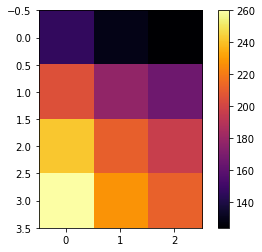

In [273]:
plt.imshow(sistema.get_solution().reshape((nvx,nvy)).T, cmap = "inferno")
plt.colorbar()

---

[Volver al índice](#Índice)

## Tres dimensiones

In [274]:
#-------------Definición de datos iniciales ----------------
lx = 0.5 # meters
ly = 0.5
lz = 0.5
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K
nx = 5 # Número de volúmenes (5 volumenes tienen 6 fronteras)
ny = 5
nz = 6
#-------------------------------------------------------------

In [275]:
# ------------Creamos la malla de acuerdo a la geometría definida por el problema
malla = Mesh(3, volumes = (nx, ny, nz), lengths = (lx, ly, lz))
#-------------Definimos fronteras ----------
malla.tag_wall_neumann("W", TA)
malla.tag_wall_source("N", TA)
malla.tag_wall_dirichlet(["E", "S", "T", "B"], [TB, TB, TB, TA])
malla.draw()

---

[Volver al índice](#Índice)

## Problema condiciones iniciales

In [29]:
#------------- Initial data definition ----------------
lx = 1 # meters
TA = 0 # °C 
TB = 0 # °C 
k  = 1 # W/m.K 
nx  = 4# number of volumes
#-------------------------------------------------------------

In [30]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [31]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP:")
print(coef.get_aP())
print("\nSp:")
print(coef.get_Sp())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\nSu:")
print(coef.get_Su())


aP:
[[[0.12]]

 [[0.08]]

 [[0.08]]

 [[0.12]]]

Sp:
[[[-0.08]]

 [[ 0.  ]]

 [[ 0.  ]]

 [[-0.08]]]

aE:
[[[-0.04]]

 [[-0.04]]

 [[-0.04]]

 [[ 0.  ]]]

aW:
[[[ 0.  ]]

 [[-0.04]]

 [[-0.04]]

 [[-0.04]]]

Su:
[[[0.]]

 [[0.]]

 [[0.]]

 [[0.]]]


In [22]:
coef.add_source(lambda x: -np.cos(x))

In [23]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 0.6 -0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [-0.2  0.4 -0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.2  0.4 -0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.2  0.4 -0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.2  0.4 -0.2  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.2  0.4 -0.2  0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.2  0.4 -0.2  0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.2  0.4 -0.2  0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.2  0.4 -0.2  0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0

In [24]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[-0.00049984 -0.00049859 -0.0004961  -0.00049236 -0.0004874  -0.00048121
 -0.00047383 -0.00046525 -0.00045552 -0.00044465 -0.00043266 -0.0004196
 -0.00040548 -0.00039035 -0.00037425 -0.00035721 -0.00033928 -0.0003205
 -0.00030092 -0.00028058]


In [25]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [-0.01149124 -0.03197452 -0.04996482 -0.06547462 -0.07852261 -0.08913361
 -0.09733855 -0.10317437 -0.10668391 -0.10791586 -0.10692457 -0.10376998
 -0.0985174  -0.09123742 -0.08200567 -0.07090267 -0.05801362 -0.04342818
 -0.02724024 -0.00954772]


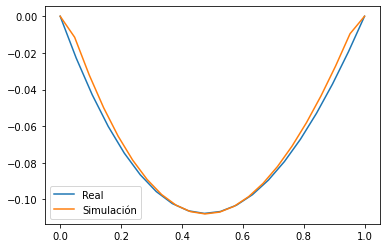

In [26]:
y = lambda x: 1 - np.cos(x) + (np.cos(1) - 1)*x
Γ_0 = Γ_1 = 0
x = np.linspace(0,1,nx+2)
x1 = np.linspace(0,1,20)
plt.plot(x1, y(x1))
plt.plot(x, [Γ_0] + list(sistema.get_solution()) + [Γ_1])
plt.legend(["Real", "Simulación"])
plt.show()

[Volver al índice](#Índice)